In [1]:
class FastaiWrapper():
    def __init__(self, model, crit):
        self.model = model
        self.crit = crit
    
    def get_layer_groups(self, precompute=False):
        return self.model

from lib.fastai.imports import *
from lib.fastai.transforms import *
from lib.fastai.learner import *
from lib.fastai.model import *
from lib.fastai.dataset import *
from lib.fastai.sgdr import *
from lib.fastai.plots import *

from ipdb import set_trace

from torchvision import datasets, transforms

def create_data():
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    path = "./data"
    
    batch_size = 256

    trainset = torchvision.datasets.CIFAR10(
        root=path, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR10(
        root=path, train=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=0)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')

    trn_X = []
    trn_y = []    
    for i, (x, y) in enumerate(tqdm(trainloader)):
        trn_X.append(x.numpy())
        trn_y.append(y.numpy())

    val_X = []
    val_y = [] 
    for i, (x, y) in enumerate(testloader):
        val_X.append(x.numpy())
        val_y.append(y.numpy())

    trn_X = np.concatenate(trn_X)
    trn_y = np.concatenate(trn_y)

    val_X = np.concatenate(val_X)
    val_y = np.concatenate(val_y)
    

    trn = [trn_X, trn_y]
    val = [val_X, val_y]

    data = ImageClassifierData.from_arrays(path, trn=trn, val=val,
                                        classes=classes)

    return data

In [2]:
data = create_data()

Files already downloaded and verified
100%|██████████| 196/196 [00:20<00:00,  9.42it/s]


In [18]:
import pickle as p
import torch

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from lib.SimpleENAS import SimpleENAS

controller = SimpleENAS()
state_dict = torch.load('controller.p')
controller.load_state_dict(state_dict)

generated_arch, _ = controller.make_architecture()
# arch_optim = optim.SGD(arch.parameters(), lr=0.08, momentum=.9, weight_decay=1e-7)
# arch.train()

# memories = p.load(open("memories.p", "rb"))

# learn = controller.LR_find(controller, memories, 128, start_lr=.1, end_lr=1)

from torch.nn import functional as F

arch = FastaiWrapper(model=generated_arch, crit=None)
learn = Learner(data=data, models=arch)
learn.crit=F.nll_loss
learn.lr_find(start_lr=.01, end_lr=.5)

  3%|▎         | 25/782 [00:33<16:50,  1.33s/it, loss=2.3] 

KeyboardInterrupt: 

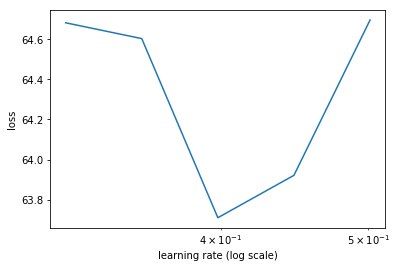

In [7]:
learn.sched.plot()

0.4

In [20]:
2 * 1e-1

0.2

In [3]:
1e-0

1.0

In [47]:
class FastaiWrapper():
    def __init__(self):
        self.model = controller
        self.crit = F.nll_loss

    def get_layer_groups(self, precompute=False):
        return self.model

wrapped_arch = FastaiWrapper()

learn = Learner(data=data, models=wrapped_arch)
learn.crit = wrapped_arch.crit
learn.model.train()

Arch(
  (arch): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(17.0, 17.0))
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1.0, 1.0))
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1.0, 1.0))
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1.0, 1.0))
    (5): Sequential(
      (0): Linear(in_features=131072, out_features=10, bias=True)
      (1): LogSoftmax()
    )
  )
)

In [48]:
learn.lr_find()


  0%|          | 0/20 [00:00<?, ?it/s]
  0%|          | 0/20 [00:16<?, ?it/s, loss=2.3020
[torch.FloatTensor of size ()]]
  5%|▌         | 1/20 [00:16<05:14, 16.58s/it, loss=2.3020
[torch.FloatTensor of size ()]]

/home/jprothero/Projects/miniconda3/envs/py3/lib/python3.6/site-packages/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]



  5%|▌         | 1/20 [00:33<10:27, 33.01s/it, loss=2.3023
[torch.FloatTensor of size ()]]
 10%|█         | 2/20 [00:33<04:57, 16.51s/it, loss=2.3023
[torch.FloatTensor of size ()]]
 10%|█         | 2/20 [00:48<07:20, 24.47s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 15%|█▌        | 3/20 [00:48<04:37, 16.31s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 15%|█▌        | 3/20 [01:05<06:09, 21.73s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 20%|██        | 4/20 [01:05<04:20, 16.30s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 20%|██        | 4/20 [01:22<05:29, 20.56s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 25%|██▌       | 5/20 [01:22<04:06, 16.45s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 25%|██▌       | 5/20 [01:40<05:00, 20.04s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 30%|███       | 6/20 [01:40<03:53, 16.70s/it, loss=2.3027
[torch.FloatTensor of size ()]]
 30%|███       | 6/20 [01:57<04:34, 19.58s/it, loss=2.3026
[torch.FloatTensor of size ()]

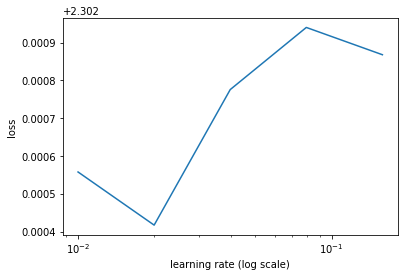

In [49]:
learn.sched.plot()

In [27]:
.03

0.1